In [68]:
def skip_lines(f, n):
    for _ in range(n):
        f.readline()
        
def rewind(f):
    f.seek(0)

The EIGENVAL files from VASP contain the energy eigenvalues at every k point.  The first paragraph gives some meta data and all other paragraphs just list the k point, the eigenvalues and their occupancy.  Below is an example exerpt from such a file.  More details on the [wiki page](https://cms.mpi.univie.ac.at/wiki/index.php/EIGENVAL) and [this forum post](https://cms.mpi.univie.ac.at/vasp-forum/viewtopic.php?f=4&t=1093).


```
    2    2    1    1
  0.2079688E+02  0.3889087E-09  0.3889087E-09  0.3889087E-09  0.5000000E-15
   1.0000000000000000E-004
  CAR⋅
 diamond Si⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅
      8     40      8

  0.5000000E+00  0.5000000E+00  0.5000000E+00  0.2500000E-01
    1       -4.016387   1.000000
    2       -1.343553   1.000000
    3        4.288919   1.000000
    4        4.288919   1.000000
    5        6.866316  -0.000000
    6        8.827936   0.000000
    7        8.827936   0.000000
    8       13.135026   0.000000

  0.4444444E+00  0.4444444E+00  0.4444444E+00  0.2500000E-01
    1       -4.169221   1.000000
    2       -1.115718   1.000000
    3        4.311477   1.000000
    4        4.311477   1.000000
    5        6.892096  -0.000000
    6        8.850769   0.000000
    7        8.850769   0.000000
    8       13.169330   0.000000
    
  ...
```

Since the whole file is separated into paragraphs, we can first write a function that reads a single paragraph from a file and then process each paragraph on their own.

In [54]:
def read_paragraph(file):
    """Read a paragraph from the given file."""
    
    lines = []       # we'll save all the lines in a list; [] creates an empty one
    
    while True:
        new = file.readline()
        if new == '\n' or new == '': # when we've reached the end of the file, readline() will return the empty string ''
            break
        else:
            lines.append(new)
            
    return lines

From the meta data only the last line is relevant to us, it gives the number of k points (40) and the number of eigenvalues (8) per k point.  Let's first write a function that reads this first paragraph and gives us the number of k points and eigenvalues.

In [29]:
def read_meta(paragraph):
    """
    Read number of eigenvalues and k points from given paragraph.  
    Must be given the first paragraph of EIGENVAL file.
    """
    
    line = paragraph[-1]  # index -1 is always the last element of a list, -2 the second to last and so on
    elems = line.split()  # split the whole line into sub strings on whitespace ("hello world".split() -> ["hello", "world"])
    
    ne = int(elems[0])    # convert from strings to integers
    nk = int(elems[1])
    
    return ne, nk

Now we can think about how to read the nth band from a paragraph in the middle of the EIGENVAL file.  The first line is always the k point and weight, then `ne` lines follow with the energy eigenvalues.  We can read those exactly like we did with the meta data.

In [28]:
def read_band(paragraph, band_index):
    """Read energy of the given band from given paragraph."""
    
    line = paragraph[band_index + 1]     # first line is the k point, so go one further
    elems = line.split()
    return float(elems[1])

Finally to plot a single band from a given file, we just have open the file, read all the paragraphs from it and then pass the paragraphs to `read_meta()` or `read_band()` respectively.

In [27]:
def read_eigenval(file, band_index):
    """Read the full band with the given index from the given file."""
    
    p = read_paragraph(file)
    ne, nk = read_meta(p)
    
    energies = []
    for i in range(nk):
        p = read_paragraph(file)
        energies.append(read_band(p, band_index))
        
    return energies

In [55]:
f = open('EIGENVAL', 'r')    # open the file with path 'EIGENVAL' in read mode ('r'), 
                             # the file must be in the same folder as the notebook
e = read_eigenval(f, 0)
f.close()
print(e)

[-4.016387, -4.169221, -4.520729, -4.924125, -5.306563, -5.637679, -5.903214, -6.096359, -6.213353, -6.252556, -6.252556, -6.200283, -6.043756, -5.784109, -5.423294, -4.964122, -4.410496, -3.76747, -3.042632, -2.244449, -2.244449, -2.247454, -2.257083, -2.274123, -2.30048, -2.338515, -2.390972, -2.46092, -2.55012, -2.660234, -2.660234, -3.109966, -3.680109, -4.280516, -4.844685, -5.334865, -5.730033, -6.018531, -6.193745, -6.252556]


In [56]:
import matplotlib.pyplot as plt

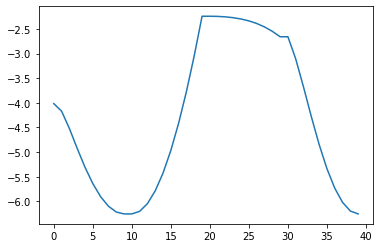

In [57]:
plt.plot(e)

Now this gives us one band from the file and to get all of them we could just call `read_eigenval()` multiple times, but that does seem wastefull.

In [59]:
f = open('EIGENVAL', 'r')
es = []
es.append(read_eigenval(f, 0))
f.seek(0) # start reading the file from the beginning
es.append(read_eigenval(f, 1))
f.seek(0)
es.append(read_eigenval(f, 2))
f.seek(0)
es.append(read_eigenval(f, 3))
f.seek(0)
es.append(read_eigenval(f, 4))
f.seek(0)
es.append(read_eigenval(f, 5))
f.seek(0)
es.append(read_eigenval(f, 6))
f.seek(0)
es.append(read_eigenval(f, 7))
f.close()

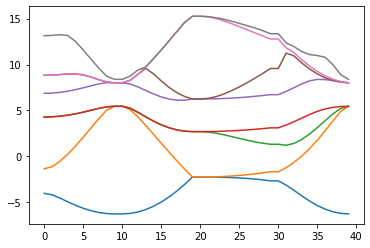

In [61]:
for e in es:
    plt.plot(e)

We can do better by modifying `read_eigenval()` as follows.

In [63]:
def read_eigenval_full(file):
    """Read all bands from the given file."""
    
    p = read_paragraph(file)
    ne, nk = read_meta(p)
    # so far so good
    
    es = []
    for j in range(ne):
        es.append([])
    
    for i in range(nk):
        p = read_paragraph(file)
        for j in range(ne):
            es[j].append(read_band(p, j))
    
    return es

In [65]:
f = open('EIGENVAL', 'r')
es = read_eigenval_full(f)
f.close()
print(es)
print(es[0])
print(es[1])

[[-4.016387, -4.169221, -4.520729, -4.924125, -5.306563, -5.637679, -5.903214, -6.096359, -6.213353, -6.252556, -6.252556, -6.200283, -6.043756, -5.784109, -5.423294, -4.964122, -4.410496, -3.76747, -3.042632, -2.244449, -2.244449, -2.247454, -2.257083, -2.274123, -2.30048, -2.338515, -2.390972, -2.46092, -2.55012, -2.660234, -2.660234, -3.109966, -3.680109, -4.280516, -4.844685, -5.334865, -5.730033, -6.018531, -6.193745, -6.252556], [-1.343553, -1.115718, -0.542198, 0.228021, 1.118371, 2.086005, 3.100823, 4.117461, 5.023745, 5.459621, 5.459621, 5.098934, 4.309972, 3.383734, 2.417025, 1.44158, 0.47371, -0.473296, -1.383753, -2.244448, -2.244448, -2.237313, -2.215878, -2.18023, -2.130343, -2.066237, -1.987939, -1.895543, -1.788969, -1.668379, -1.668379, -1.22263, -0.651877, 0.039654, 0.848579, 1.767172, 2.782065, 3.862116, 4.904819, 5.459621], [4.288919, 4.311477, 4.376761, 4.484761, 4.633226, 4.816444, 5.023027, 5.229437, 5.394619, 5.459639, 5.459639, 5.256631, 4.808616, 4.310926, 3.8

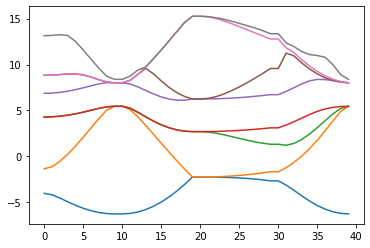

In [66]:
for e in es:
    plt.plot(e)